### Acquire or generate dataset

In [ ]:
%cd /content/drive/MyDrive/3dgs/gaussian-splatting
!python render_ray.py -m /content/drive/MyDrive/3dgs/data/pre-trained/3DGS/playroom -s /content/drive/MyDrive/3dgs/data/tandt/playroom --view_index 20 --skip_test

## Sample Dataset Analysis

### Read dataset

In [ ]:
import polars as pl
import numpy as np

sample_data_path = '/content/drive/MyDrive/3dgs/gaussian-splatting/update_playroom_20.csv'

df = pl.read_csv(sample_data_path)
print(df.head())

### Transmittance/Depth Graph
We pick samples from the dataset, and plot the transmittance vs depth graph for each sampled pixel

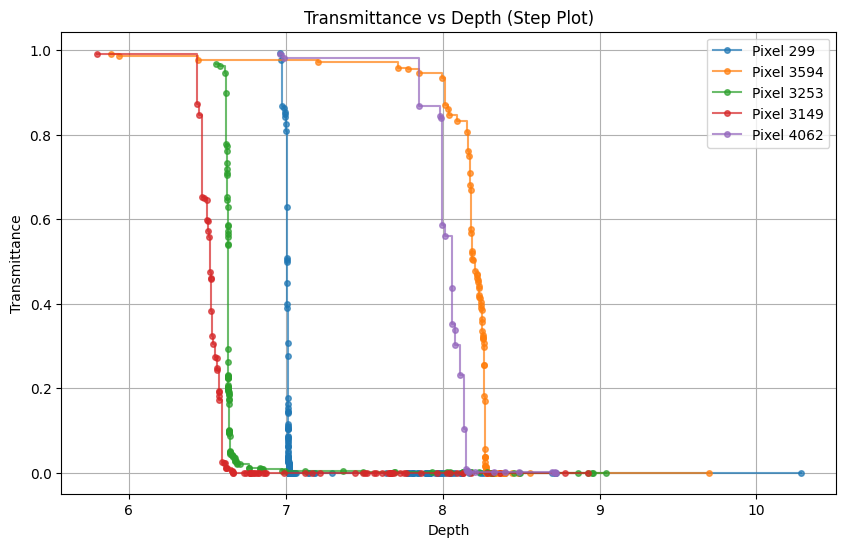

In [ ]:
import matplotlib.pyplot as plt
import random

num_samples = 5  # Number of random samples you want to plot
random_pixel_nums = random.sample(list(df['pixelNum']), num_samples)

plt.figure(figsize=(10, 6))
for pixel_num in random_pixel_nums:
    row = df[df['pixelNum'] == pixel_num].iloc[0]

    transmittances = []
    depths = []
    T = 1.0  # Start transmittance at 1 (fully transparent)

    for i in range(500):
        alpha_val = row.get(f'Gaussian_{i}_alpha', 0.0)
        depth_val = row.get(f'Gaussian_{i}_depth', 0.0)

        # Stop processing when 0.0 is encountered
        if alpha_val == 0.0 or depth_val == 0.0:
            break

        T *= (1 - alpha_val)
        transmittances.append(T) 
        depths.append(depth_val)

    if len(transmittances) == len(depths) and len(transmittances) > 0:
        # Plot the transmittance vs depth as a step plot (level graph)
        plt.step(depths, transmittances, where='post', label=f'Pixel {pixel_num}', alpha=0.7, marker="o", markersize=4)

plt.xlabel('Depth')
plt.ylabel('Transmittance')
plt.title('Transmittance vs Depth (Step Plot)')
plt.grid(True)
plt.legend() 
plt.show()

## Gaussian Splats Statistics

### Count Cluster
This is an upper bound for clusters as we includes all splat regardless of whether it has contribution.

In [ ]:
from scipy.stats import percentileofscore
from tqdm import tqdm  # Progress bar

file_path = '/content/drive/MyDrive/3dgs/gaussian-splatting/splat_tile.csv'

depth_diff = []
counts = []
epsilon = 0.1174

with open(file_path, "r") as file:
    for line in tqdm(file, desc="Processing lines"):
        line = line.strip()
        values = [val for val in line.split(",") if val]

        count = 0
        prev = 0.0
        for depth_val in map(float, values):
            if (depth_val - prev) > epsilon:
                depth_diff.append(depth_val - prev)
                count += 1
                prev = depth_val
        counts.append(count)  # Add count for this line to counts list

# Calculate statistics
print('Max number of clusters:', np.max(counts))
print('Min number of clusters:', np.min(counts))
print('1st percentile:', np.percentile(counts, 1))
print('90th percentile:', np.percentile(counts, 99))
print('Variance of number of clusters:', np.var(counts))
print('Average number of clusters:', np.mean(counts))

print("\n")

# Depth statistics
print('Max depth diff:', np.max(depth_diff))
print('Min depth diff:', np.min(depth_diff))
print('1st percentile:', np.percentile(depth_diff, 1))
print('5th percentile:', np.percentile(depth_diff, 5))
print('99th percentile:', np.percentile(depth_diff, 99))
print('Average depth diff:', np.mean(depth_diff))
print('Variance of depth diff:', np.var(depth_diff))


Processing lines: 4108it [00:01, 2919.05it/s]


Max number of clusters: 45
Min number of clusters: 17
1st percentile: 18.0
90th percentile: 43.0
Variance of number of clusters: 36.40823424784945
Average number of clusters: 31.046738072054527


Max depth diff: 2.9618900000000004
Min depth diff: 0.11740000000000039
1st percentile: 0.11743999999999932
5th percentile: 0.11760999999999999
99th percentile: 1.88721
Average depth diff: 0.295076855417908
Variance of depth diff: 0.14348142221509044


### Coverage Check
Check whether the dataset cover all contributing splats in 500 columns

In [ ]:
chunksize = 10000
total_neg_ones = 0
total_rows = 0

# Read the CSV in chunks and process
for chunk in pl.read_csv('/content/drive/MyDrive/3dgs/gaussian-splatting/alpha_vals.csv', batch_size=chunksize):
    neg_ones_in_chunk = chunk.filter(pl.col('Gaussian_499_depth') == 0.0).shape[0]

    total_neg_ones += neg_ones_in_chunk
    total_rows += chunk.shape[0]

# Calculate and print the percentage
percentage = total_neg_ones / total_rows
print(percentage)

### Read Dataset
Read the dataset for entire view using `polars`

In [ ]:
import polars as pl
import numpy as np

input_file_path = '/content/drive/MyDrive/3dgs/gaussian-splatting/alpha_vals.csv'

df = pl.read_csv(input_file_path)
print(df.head())

### Alpha Histogram
Shows the distribution of alpha values of all contributing splats

In [ ]:
alpha_columns = [col for col in df.columns if 'alpha' in col]

valid_alphas = (
    df.select(alpha_columns)  # Select only alpha columns
    .to_numpy()               # Convert to NumPy array for easier filtering
)
valid_alphas = valid_alphas[valid_alphas != 0]

percentile_1 = np.percentile(valid_alphas, 1)
percentile_98 = np.percentile(valid_alphas, 98)
mean_val = np.mean(valid_alphas)

print(f"Total valid alpha values: {len(valid_alphas)}")
print(f"1st percentile: {percentile_1}")
print(f"98th percentile: {percentile_98}")
print(f"Mean: {mean_val}")
plt.hist(valid_alphas, bins=100)
plt.show()
